Module Code ： FC724
Class/Group:  Group C
Module Title： Programming Practical Applications
Assessment Title ： Project ATI 2
Tutor Name: Jack Parkinson
Student GUID Number: P442115
Date of Submission: 2025/3/2


introduction：
background:
Analyze the data between different countries according to the data set, from 2000 to 2023, which includes Total Energy Consumption (TWh),Renewable Energy (%),Government Investment (Million USD), Emissions Reduction (%),Solar , Wind,Hydro,Geothermal,Biomass,Other Renewables.


the key to the question：
1.Annual trends in the share of renewable energy in each country.
2.The relationship between government investment and the share of renewable energy
3.Share of renewable energy in each country in the latest year


Import and load the CSV file
Perform data cleaning

In [ ]:
import pandas as pd  # Import the pandas library for data manipulation
import sqlite3  # Import sqlite3 for database operations (not used in this script)

# Define the file path of the dataset
file_path = r"C:\Users\段\Desktop\724\Renewable_Energy_Adoption.csv"

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Keep only the first 240 rows of data
df = df.head(240)

# Reset the index to start from 1 instead of 0
df.index = range(1, len(df) + 1)

# Set pandas display option to show up to 300 rows in the output
pd.set_option('display.max_rows', 300)

def fill_gov_investment(dataframe):
    """
    Fill missing values in the 'Government Investment (Million USD)' column with 
    the average investment for the corresponding country.
    
    Args:
        dataframe (pd.DataFrame): The input DataFrame containing renewable energy data.
        
    Returns:
        pd.DataFrame: The DataFrame with missing government investment values filled.
    """
    country_avg = {}  # Dictionary to store average investment per country
    
    # Calculate the average investment for each country
    for country in dataframe['Country'].unique():
        country_data = dataframe[dataframe['Country'] == country]
        avg_investment = country_data['Government Investment (Million USD)'].mean()
        country_avg[country] = avg_investment if pd.notna(avg_investment) else 0  # Store 0 if no data available
    
    # Fill missing values using the calculated average
    for idx, row in dataframe.iterrows():
        if pd.isna(row['Government Investment (Million USD)']):
            current_country = row['Country']
            dataframe.at[idx, 'Government Investment (Million USD)'] = country_avg[current_country]
    
    return dataframe

# Apply the function to fill missing government investment values
df = fill_gov_investment(df)

# Define the columns representing different types of renewable energy sources
energy_cols = ['Solar', 'Wind', 'Hydro', 'Geothermal', 'Biomass', 'Other Renewables']

# Convert energy-related columns to numeric, coercing errors to NaN
df[energy_cols] = df[energy_cols].apply(pd.to_numeric, errors='coerce')

# Convert the 'Renewable Energy (%)' column to numeric, coercing errors to NaN
df['Renewable Energy (%)'] = pd.to_numeric(df['Renewable Energy (%)'], errors='coerce')

def compute_country_energy_avg(dataframe, cols):
    """
    Compute the average energy values for each country and energy type.
    
    Args:
        dataframe (pd.DataFrame): The input DataFrame containing energy data.
        cols (list): A list of energy-related column names.
        
    Returns:
        dict: A dictionary with (country, energy type) as keys and average values as values.
    """
    avg_dict = {}  # Dictionary to store average values
    
    # Compute the average for each country and energy type
    for country in dataframe['Country'].unique():
        for col in cols:
            country_data = dataframe[dataframe['Country'] == country]
            avg_val = country_data[col].mean()
            avg_dict[(country, col)] = avg_val if pd.notna(avg_val) else 0  # Store 0 if no data available
    
    return avg_dict

# Compute the country-wise energy averages
country_energy_avg = compute_country_energy_avg(df, energy_cols)

def fill_energy_values(row, cols, country_avg_dict):
    # Identify missing energy columns
    missing_cols = [col for col in cols if pd.isna(row[col])]
    num_missing = len(missing_cols)

    if num_missing == 1:  # If only one energy column is missing
        missing_col = missing_cols[0]
        if pd.isna(row['Renewable Energy (%)']):  # If total renewable energy percentage is also missing
            total_known = row[[col for col in cols if pd.notna(row[col])]].sum()
            row['Renewable Energy (%)'] = total_known  # Set the total to the sum of known values
        else:
            # Calculate the missing value as the difference between total and known values
            known_sum = row[[col for col in cols if col != missing_col and pd.notna(row[col])]].sum()
            row[missing_col] = row['Renewable Energy (%)'] - known_sum
    else:
        # If multiple values are missing, use country-wise averages
        for col in cols:
            if pd.isna(row[col]):
                row[col] = country_avg_dict.get((row['Country'], col), 0)
        
        # If total renewable energy percentage is missing, sum up the energy values
        if pd.isna(row['Renewable Energy (%)']):
            row['Renewable Energy (%)'] = row[cols].astype(float).fillna(0).sum()
    
    return row

# Apply the function to fill missing energy values
df = df.apply(lambda row: fill_energy_values(row, energy_cols, country_energy_avg), axis=1)

# Fill any remaining NaN values in energy columns with 0
df[energy_cols] = df[energy_cols].fillna(0)

# Print the first 240 rows of the processed DataFrame
print(df.head(240))



In [24]:
import sqlite3
import pandas as pd

df = df.rename(columns={"Renewable Energy (%)": "Renewable_Energy_Percentage",
                        "Government Investment (Million USD)": "Government_Investment",
                        "Other Renewables": "Other_Renewables"})

connect = sqlite3.connect("RenewableEnergy.db")
cursor = connect.cursor()

cursor.execute('''
    CREATE TABLE IF NOT EXISTS EnergyData (
        Country TEXT,
        Year INTEGER,
        "Total Energy Consumption (TWh)" INTEGER,
        "Renewable Energy (%)" REAL,
        "Government Investment (Million USD)" REAL,
        "Emissions Reduction (%)" REAL,
        Solar REAL,
        Wind REAL,
        Hydro REAL,
        Geothermal REAL,
        Biomass REAL,
        "Other Renewables" REAL
    )
''')
connect.commit()

df.to_sql("EnergyData", connect, if_exists="replace", index=False)

print(" The data has been successfully stored in the SQLite database！")

query_1 = '''
    SELECT Country, "Renewable Energy (%)"
    FROM EnergyData
    WHERE Year = 2017
      AND "Renewable Energy (%)" IS NOT NULL
    ORDER BY "Renewable Energy (%)" DESC
    LIMIT 5;
'''
df_result_1 = pd.read_sql(query_1, connect)
print("\n The top 5 countries with the highest share of renewable energy in 2017:\n", df_result_1)

query_2 = '''
    SELECT 
      AVG(Solar)         AS AvgSolar, 
      AVG(Wind)         AS AvgWind,
      AVG(Hydro)        AS AvgHydro,
      AVG(Geothermal)   AS AvgGeothermal,
      AVG(Biomass)      AS AvgBiomass,
      AVG("Other Renewables") AS AvgOtherRenewables
    FROM EnergyData;
'''
df_result_2 = pd.read_sql(query_2, connect)
print("\n The average proportion of all types of renewable energy:\n", df_result_2)

query_3 = '''
    SELECT Country, AVG("Government Investment (Million USD)") AS MaxInvestment
    FROM EnergyData
    WHERE "Government Investment (Million USD)" IS NOT NULL
    GROUP BY Country
    ORDER BY MaxInvestment DESC
    LIMIT 5;
'''
df_result_3 = pd.read_sql(query_3, connect)
print("\n Top 5 countries for government investment：\n", df_result_3)

country_name = 'USA'  
query_4 = f'''
    SELECT * 
    FROM EnergyData
    WHERE Country = '{country_name}'
    ORDER BY Year;
'''
df_result_4 = pd.read_sql(query_4, connect)
print(f"\n {country_name} All data of：\n", df_result_4)


energy_type = 'Solar'  
query_5 = f'''
    SELECT Country, {energy_type}
    FROM EnergyData
    WHERE Year = 2017
      AND {energy_type} IS NOT NULL
    ORDER BY {energy_type} DESC
    LIMIT 5;
'''
df_result_5 = pd.read_sql(query_5, connect)
print(f"\n The year 2017 {energy_type} Top 5 countries：\n", df_result_5)

query_6 = '''
    SELECT AVG("Renewable Energy (%)") AS GlobalAvg
    FROM EnergyData
    WHERE Year = 2017
      AND "Renewable Energy (%)" IS NOT NULL;
'''
df_result_6 = pd.read_sql(query_6, connect)
print("\n Global average share of renewable energy in 2017：\n", df_result_6)

connect.close()


 The data has been successfully stored in the SQLite database！

 The top 5 countries with the highest share of renewable energy in 2017:
    Country "Renewable Energy (%)"
0      USA   Renewable Energy (%)
1    China   Renewable Energy (%)
2    India   Renewable Energy (%)
3  Germany   Renewable Energy (%)
4   Brazil   Renewable Energy (%)

 The average proportion of all types of renewable energy:
    AvgSolar   AvgWind  AvgHydro  AvgGeothermal  AvgBiomass  AvgOtherRenewables
0  2.066762  2.289164  2.252989        2.09041    2.160237                 0.0

 Top 5 countries for government investment：
         Country  MaxInvestment
0           USA            0.0
1            UK            0.0
2  South Africa            0.0
3         Japan            0.0
4         India            0.0

 USA All data of：
    Country  Year  Total Energy Consumption (TWh)  Renewable_Energy_Percentage  \
0      USA  2000                            2383                     7.027076   
1      USA  2001          

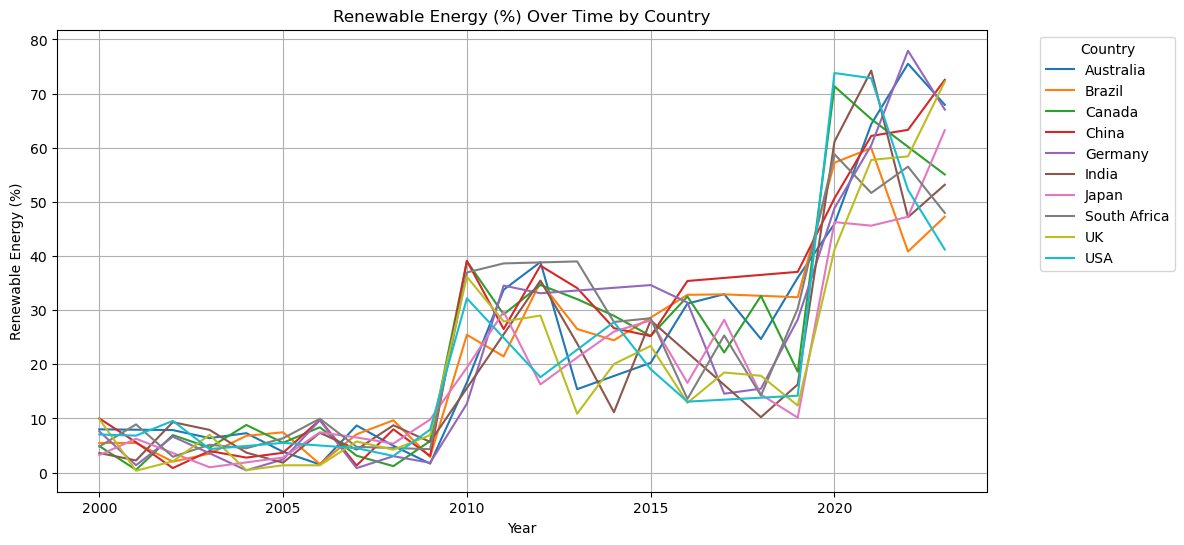

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Use the full file path you provided
file_path = "C:/Users/段/Desktop/724/Renewable_Energy_Adoption.csv"
df = pd.read_csv(file_path)

# Clean up spaces in column names
df.columns = df.columns.str.strip()

# Sort data by country and year
df.sort_values(['Country', 'Year'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Interpolate missing values in the "Renewable Energy (%)" column
df['Renewable Energy (%)'] = df.groupby('Country')['Renewable Energy (%)'].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))

# Ensure the column is of a numeric type
df['Renewable Energy (%)'] = pd.to_numeric(df['Renewable Energy (%)'], errors='coerce')

# Create the chart
plt.figure(figsize=(12, 6))
for country, sub_df in df.groupby('Country'):
    plt.plot(sub_df['Year'], sub_df['Renewable Energy (%)'], label=country)

plt.title("Renewable Energy (%) Over Time by Country")
plt.xlabel("Year")
plt.ylabel("Renewable Energy (%)")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Display the chart (for your local environment)
plt.show()

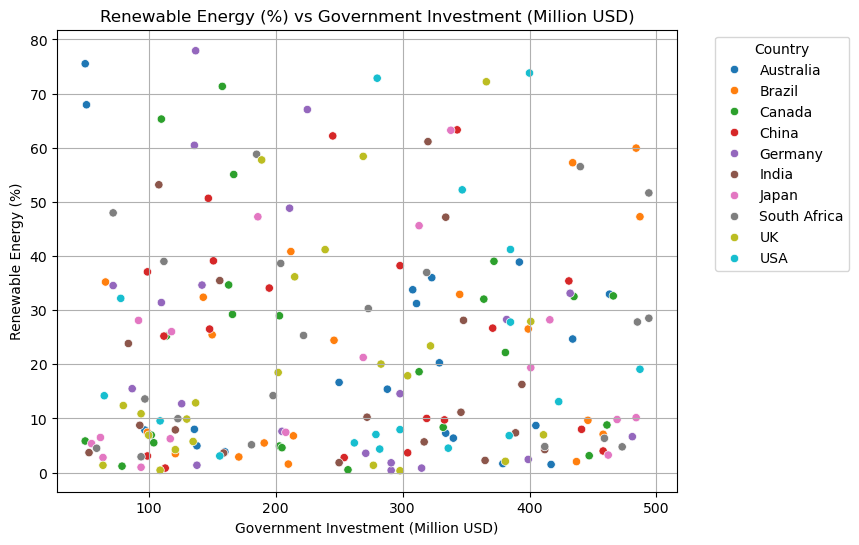

In [36]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Government Investment (Million USD)', y='Renewable Energy (%)', hue='Country')
plt.title("Renewable Energy (%) vs Government Investment (Million USD)")
plt.xlabel("Government Investment (Million USD)")
plt.ylabel("Renewable Energy (%)")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

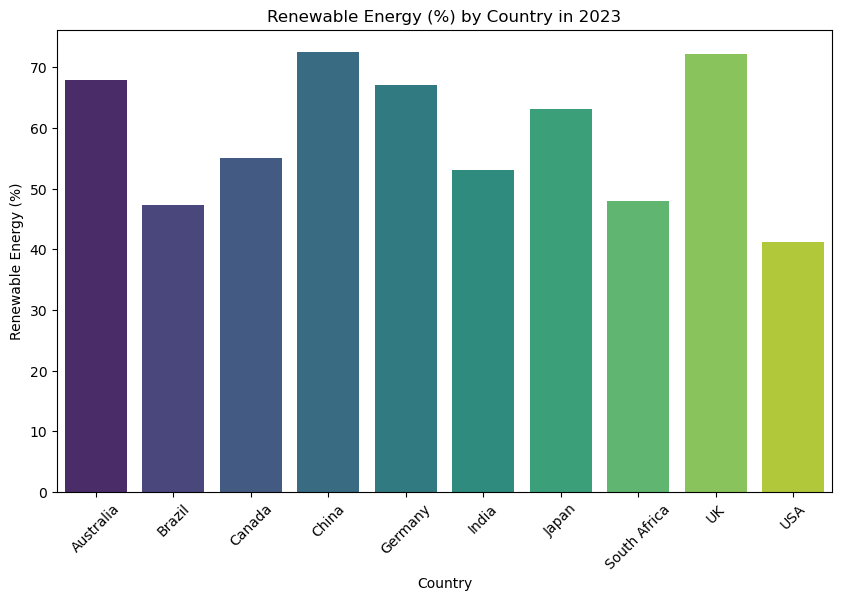

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use the full file path you provided
file_path = "C:/Users/段/Desktop/724/Renewable_Energy_Adoption.csv"
df = pd.read_csv(file_path)

# Clean up spaces in column names
df.columns = df.columns.str.strip()

# Interpolate and convert missing values in the "Renewable Energy (%)" column
df['Renewable Energy (%)'] = pd.to_numeric(df['Renewable Energy (%)'], errors='coerce')
df.sort_values(['Country', 'Year'], inplace=True)
df['Renewable Energy (%)'] = df.groupby('Country')['Renewable Energy (%)'].transform(lambda x: x.interpolate(method='linear', limit_direction='both'))

# Find the latest year in the dataset
latest_year = df['Year'].max()
df_latest = df[df['Year'] == latest_year]

# Create the bar plot
plt.figure(figsize=(10,6))
sns.barplot(data=df_latest, x='Country', y='Renewable Energy (%)', hue='Country', palette='viridis', legend=False)

# Add titles and labels
plt.title(f"Renewable Energy (%) by Country in {latest_year}")
plt.xlabel("Country")
plt.ylabel("Renewable Energy (%)")
plt.xticks(rotation=45)

# Display the chart (for your local environment)
plt.show()

During the completion of this assignment, I learned and applied both SQL and Python, which helped me effectively process, analyze, and visualize the data. The reflection on the entire process can be summarized in the following aspects:

1. The Importance of Data Cleaning
Data cleaning is one of the most crucial steps in the entire analysis process. Before starting, I found that there were a lot of missing values in the dataset, and I needed to handle them using interpolation and filling techniques. For example, the Renewable Energy (%) column had missing data, which was a common issue. I effectively filled these gaps by interpolating within each country and using forward-fill methods. This process deepened my understanding of how important data cleaning is for the accuracy and reliability of analysis results.
2. Improvement in SQL Querying Skills
Using SQL to query the data allowed me to better understand how to efficiently extract and manipulate information from a database. Through different SQL queries, I was able to filter out the necessary data, such as the countries with the highest government investment and the countries with the highest renewable energy percentage in 2017. 
3. Understanding and Application of Data Visualization 
In terms of data visualization, I didn't manage to successfully display all the charts. There was still one chart that I failed to present properly. Charts can enhance the readability of data and also help me better understand the data from different perspectives. However, I didn't do a very good job.
4. Reflection and Summary
For the digital visualization part, I should have worked harder. I need to further understand the code and practice more. I should have given myself more time to complete my assignment. Through this assignment, I have improved my understanding of data processing, SQL queries and data visualization.